In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing import image_dataset_from_directory


CWD_PATH = os.getcwd()
MODEL_PATH = os.path.join(CWD_PATH, 'train_models')
MODEL_NAME = 'FLOWER_BS32_EPOCH20_DROP00'
MODEL_NAME_PATH = os.path.join(MODEL_PATH,MODEL_NAME)
SAVED_MODEL_PATH = os.path.join(MODEL_NAME_PATH, '{}_model'.format(MODEL_NAME))
SAVED_FINETUNE_MODEL_PATH = os.path.join(MODEL_NAME_PATH, '{}_finetune_model'.format(MODEL_NAME))
DATA_PATH = os.path.join(CWD_PATH, 'flower_photos')



BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SHAPE_SIZE = (224,224,3)
VALIDATION_SPLIT = 0.2
STEPS_PER_EPOCH = 1
initial_epochs = 20
fine_tune_epochs = 20
final_batch_size = 32
DROPU_OUT = 0.0
base_learning_rate = 0.0001
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [32]:
train_dataset = image_dataset_from_directory(DATA_PATH,
                                             shuffle=True,
                                             validation_split=VALIDATION_SPLIT,
                                             subset="training",
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(DATA_PATH,
                                                  shuffle=True,
                                                  validation_split=VALIDATION_SPLIT,
                                                  subset="validation",
                                                  seed=123,                                                  
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

class_names = train_dataset.class_names

print('classes ', class_names)

## take 1 / 5 batch for test data
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
classes  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of training batches: 92
Number of validation batches: 19


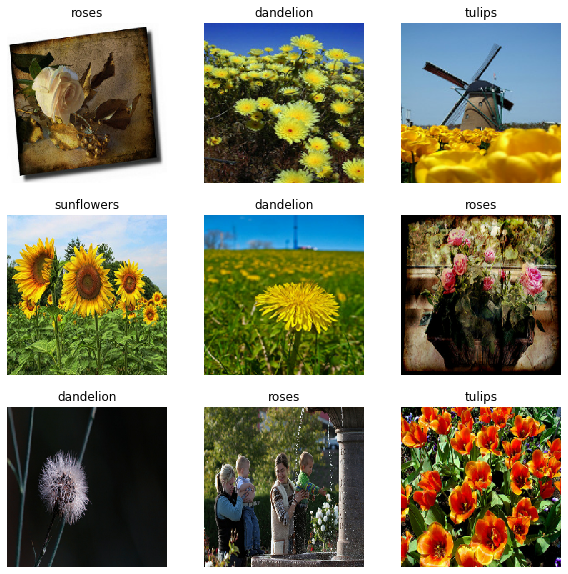

In [33]:
#visualize train data
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
# define loss Object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def get_optimizer(reduce_learning=True):
    if(reduce_learning):
        return tf.keras.optimizers.Adam(lr=base_learning_rate)
    else:
        return tf.keras.optimizers.Adam()

optimizer_finetune = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10)

In [35]:
base_model = tf.keras.applications.MobileNetV2(input_shape=SHAPE_SIZE, include_top=False, weights='imagenet')
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#feature extraction
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [36]:
## data augmentation & drop out to overcome the overfit
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=SHAPE_SIZE),  
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])    

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()    
#softmax set the Dense with number of classes
prediction_layer = tf.keras.layers.Dense(len(class_names), activation = 'softmax')
inputs = tf.keras.Input(shape=SHAPE_SIZE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
if(DROPU_OUT > 0):
    x = tf.keras.layers.Dropout(DROPU_OUT)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)
model.summary()

Model: "FLOWER_BS32_EPOCH20_DROP00"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)  

In [37]:
model.compile(optimizer=get_optimizer(),loss=loss_object,metrics=['accuracy'])

19/19 [==============================] - 9s 458ms/step - loss: 1.6119 - accuracy: 0.2145
initial loss: 1.61
initial accuracy: 0.21
Epoch 1/20
92/92 [==============================] - 61s 658ms/step - loss: 1.6075 - accuracy: 0.2340 - val_loss: 1.6007 - val_accuracy: 0.2426
Epoch 2/20
92/92 [==============================] - 57s 618ms/step - loss: 1.6004 - accuracy: 0.2459 - val_loss: 1.6003 - val_accuracy: 0.2426
Epoch 3/20
92/92 [==============================] - 58s 625ms/step - loss: 1.5990 - accuracy: 0.2459 - val_loss: 1.5995 - val_accuracy: 0.2426
Epoch 4/20
92/92 [==============================] - 58s 628ms/step - loss: 1.5982 - accuracy: 0.2456 - val_loss: 1.5987 - val_accuracy: 0.2426
Epoch 5/20
92/92 [==============================] - 58s 630ms/step - loss: 1.5971 - accuracy: 0.2463 - val_loss: 1.5979 - val_accuracy: 0.2442
Epoch 6/20
92/92 [==============================] - 58s 631ms/step - loss: 1.5963 - accuracy: 0.2476 - val_loss: 1.5971 - val_accuracy: 0.2442
Epoch 7/20


Text(0.5, 0, 'epoch')

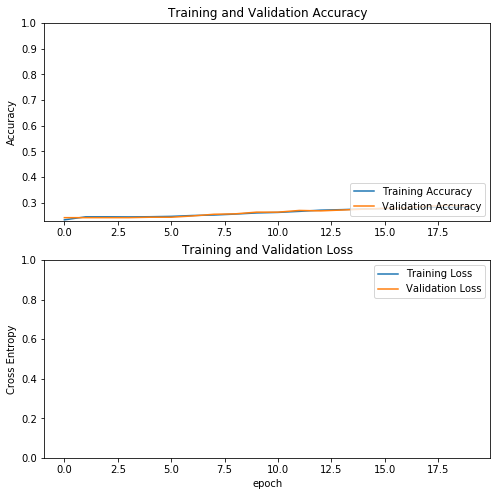

In [38]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [ ]:
#evaluate model
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test Loss :', loss)

In [ ]:
# visualize 
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
print(predicted_ids)
#predicted_class_names = class_names[predicted_ids]
"""Let's look at the true labels and predicted ones."""
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow((image_batch[n] * 255).astype(np.uint8))
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(class_names[predicted_ids[n]], color=color)
  plt.axis('off')
    
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
# confusion prediction
image_batch_conf, label_batch_conf = test_dataset.as_numpy_iterator().next()
y_pred=np.argmax(model.predict(image_batch_conf),axis=1)
print(tf.math.confusion_matrix(labels=label_batch_conf, predictions=y_pred, num_classes=len(class_names)))

In [ ]:
#fine tuning
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer = optimizer_finetune,
              loss=loss_object, 
              metrics=['accuracy'])

model.summary()


total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         batch_size=final_batch_size,
                         validation_data=validation_dataset,
                         callbacks=finetune_callbacks)

#loss1, accuracy1 = model.evaluate(test_dataset)
#print('Test accuracy :', accuracy1)
#print('Test Loss :', loss1)
#tf.saved_model.save(model, SAVED_FINETUNE_MODEL_PATH)

In [ ]:
#evaluate finetune model
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test Loss :', loss)